# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [4]:
data_processed = "../../data/processed/"
data_interim = "../../data/interim/"
data_external = "../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_nodes.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

G = nx.read_gml(graph_data+"nohub_fullgraph.gml", destringizer=int)

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

,Número de nodos
bert_group,1040
complex,421
disease,15039
gene_protein,17322
pathway,2017
total,35839


,Número de enlaces
disease_disease,16433.0
form_complex,1885.0
gda,84014.0
pathway_protein,42643.0
ppi,110051.0
total,255026.0


In [4]:
display(graph_node_data.head())
display(graph_edge_data.head())
display(disease_attributes.head())

,node_index,node_id,node_name,node_type,node_source
0,0,1,A1BG,gene_protein,disgenet
1,19599,C0019209,Hepatomegaly,disease,disgenet
2,34251,R-HSA-114608,Platelet degranulation,pathway,primekg_REACTOME
3,653,10422,UBAC1,gene_protein,hippie
4,13168,63891,RNF123,gene_protein,disgenet


,y_index,x_index,edge_index,x_id,y_id,x_type,y_type,edge_type,edge_source,edge_source_index
0,0,19599,376057,C0019209,1,disease,gene_protein,gda,disgenet,0.0
1,0,34251,468555,R-HSA-114608,1,pathway,gene_protein,pathway_protein,primekg,NaN
2,0,653,10692,10422,1,gene_protein,gene_protein,ppi,hippie,357083.0
3,0,13168,248192,63891,1,gene_protein,gene_protein,ppi,hippie,358639.0
4,0,6638,110237,284403,1,gene_protein,gene_protein,ppi,hippie,297494.0


,node_index,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
0,19599,C0019209,Hepatomegaly,phenotype,NaN,NaN,NaN,Abnormally increased size of the liver.,NaN,C23;C06,"Pathological Conditions, Signs and Symptoms; D...",disgenet
1,20754,C0036341,Schizophrenia,disease,5090.0,schizophrenia (disease),A major psychotic disorder characterized by ab...,A disorder in which the individual suffers fro...,NaN,F03,Mental Disorders,disgenet
2,24165,C0376358,Malignant neoplasm of prostate,disease,8315.0,prostate cancer,A primary or metastatic malignant tumor involv...,A primary or metastatic malignant tumor involv...,NaN,C04;C12,Neoplasms; Male Urogenital Diseases,disgenet
3,18773,C0006142,Malignant neoplasm of breast,disease,7254.0,breast cancer,A primary or metastatic malignant neoplasm inv...,A primary or metastatic malignant neoplasm inv...,NaN,C04;C17,Neoplasms; Skin and Connective Tissue Diseases,disgenet
4,18732,C0005695,Bladder Neoplasm,disease,4987.0,urinary bladder neoplasm,"A benign or malignant, primary or metastatic n...","A benign or malignant, primary or metastatic n...",NaN,C04;C13;C12,Neoplasms; Female Urogenital Diseases and Preg...,disgenet


# Armo grafo y subgrafos

In [55]:
def attributes_from_pd(G:nx.Graph,df:pd.DataFrame,attributes:dict,indexcol):
    """Dados un grafo G y un dataframe df con atributos de sus nodos, especificamos los atributos
    que queremos agregar a los nodos en un diccionario con formato {nombre_columna:nombre_atributo}. 
    La función arma un diccionario con los atributos y el nombre que le queremos poner, indexado con el identificador de nodo que elegimos 
    y los asigna a los nodos del grafo"""
    for attribute,name in attributes.items():
        nx.set_node_attributes(G,pd.Series(df.set_index(indexcol)[attribute]).to_dict(),name)

def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

def get_edge_dict(G):
    edge_dict = {}
    for edge_data in list(G.edges(data=True)):
        edge_index = edge_data[2]["edge_index"]
        edge_type = edge_data[2]["edge_type"]
        edge_source = edge_data[0]
        edge_target = edge_data[1]
        edge_dict[edge_index] = {"edge_type":edge_type, "nodes":(edge_source,edge_target)}
    return edge_dict

def get_edges_from(node_index):
    edges_from = graph_edge_data[(graph_edge_data.x_index == node_index)]
    return edges_from

Armo subgrafo de enfermedades

In [57]:
edges_enfermedades = graph_edge_data[graph_edge_data.edge_type == "disease_disease"]

nodos_enfermedades = graph_node_data[(graph_node_data.node_type == "disease") | (graph_node_data.node_type == "bert_group")]
nodos_disease = graph_node_data[graph_node_data.node_type == "disease"]
nodos_bert = graph_node_data[graph_node_data.node_type == "bert_group"]

disease_attributes["node_type"] = "disease"
disease_attributes = pd.concat([disease_attributes,nodos_bert])

DD = nx.from_pandas_edgelist(edges_enfermedades,source="x_index",target="y_index")
DD_attributes = {"node_name":"node_name","node_type":"node_type","node_id":"node_id","node_source":"node_source","disgenet_type":"disgenet_type","diseaseClassMSH":"diseaseClassMSH","diseaseClassNameMSH":"diseaseClassNameMSH"}
attributes_from_pd(DD,disease_attributes,DD_attributes,"node_index")

Armo subgrafos de proteínas y de asociaciones GDA

In [59]:
edges_proteinas = graph_edge_data[(graph_edge_data.edge_type == "ppi") | (graph_edge_data.edge_type == "form_complex") | (graph_edge_data.edge_type == "pathway_protein")]
nodos_proteinas = graph_node_data[(graph_node_data.node_type == "gene_protein") | (graph_node_data.node_type == "complex") | (graph_node_data.node_type == "pathway")]
PPI = nx.from_pandas_edgelist(edges_proteinas,source="x_index",target="y_index")
PPI_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}

edges_gda = graph_edge_data[graph_edge_data.edge_type == "gda"]
nodos_gda = graph_node_data[graph_node_data.node_source == "disgenet"]

GDA = nx.from_pandas_edgelist(edges_gda,source="x_index",target="y_index")
GDA_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source"}

for network,attr in zip([PPI,GDA],[PPI_attributes,GDA_attributes]):
    attributes_from_pd(network,graph_node_data,attr,"node_index")

In [60]:
graphs = {"Grafo completo":G, "Disease layer":DD, "Protein layer":PPI, "GDA": GDA}
stats = {name:{"Número de nodos":graph.number_of_nodes(), "Número de enlaces":graph.number_of_edges()} for name,graph in graphs.items()}
display(pd.DataFrame(stats))

,Grafo completo,Disease layer,Protein layer,GDA
Número de nodos,35839,12368,18525,20855
Número de enlaces,255026,16433,154579,84014


In [61]:
# nx.write_gml(GDA, graph_data+"nohub_gda_network.gml")

Me quedo con la componente gigante

# Diferencio enlaces bert_disease de disease_disease

Esto es por si más adelante quiero tratarlos como algo diferente 

In [10]:
df1 = pd.read_csv(graph_data+"bert_edge_reference.csv").drop(columns=["Unnamed: 0"])
df2 = pd.read_csv(graph_data+"disease_bert_edges.csv").drop(columns=["Unnamed: 0"])

In [62]:
disease_mappings = pd.read_csv(data_processed+"graph_data/disease_mappings.csv")
bert_edges = pd.read_csv(data_processed+"graph_data/bert_edge_reference.csv").drop(columns=["Unnamed: 0"])

dd = graph_edge_data[graph_edge_data.edge_type == "disease_disease"]

temp_df = pd.merge(dd,bert_edges[["x_index","y_index","relation"]],left_on=["x_index","y_index"], right_on=["x_index","y_index"], how="inner").rename(columns={"relation":"disease_edge_type"})

bert_edges_inverted = bert_edges.rename(columns={"x_index":"y_index","y_index":"x_index"})

temp_df_inverted = pd.merge(dd,bert_edges_inverted[["x_index","y_index","relation"]],left_on=["x_index","y_index"], right_on=["x_index","y_index"], how="inner").rename(columns={"relation":"disease_edge_type"})

final_bert_edges = pd.concat([temp_df,temp_df_inverted])

final_bert_edges.to_csv(graph_data+"disease_bert_edges.csv")

In [63]:
disease_edge_types = pd.merge(dd,final_bert_edges[["x_index","y_index","disease_edge_type"]], left_on=["x_index","y_index"], right_on=["x_index","y_index"],how="left")
disease_edge_types.disease_edge_type = disease_edge_types.disease_edge_type.fillna("disease_disease")
num_bert_map = disease_edge_types.disease_edge_type.value_counts()["disease_bert"]/2
display(pd.DataFrame(disease_edge_types.disease_edge_type.value_counts()/2))

,disease_edge_type
disease_disease,11456.0
disease_bert,4977.0


In [64]:
num_bert_mondo = len(disease_edge_types[(disease_edge_types.disease_edge_type == "disease_disease") & ((disease_edge_types.x_type == "bert_group")|(disease_edge_types.y_type == "bert_group"))])/2
num_true_disease_disease = len(disease_edge_types[(disease_edge_types.disease_edge_type == "disease_disease") & (disease_edge_types.x_type != "bert_group") & (disease_edge_types.y_type != "bert_group")])/2

In [65]:
num_bert_bert = len(disease_edge_types[(disease_edge_types.x_type == "bert_group") & (disease_edge_types.y_type == "bert_group")])/2

In [66]:
num_true_disease_disease+num_bert_mondo+num_bert_map

16433.0

In [67]:
display(pd.DataFrame.from_dict({"Count":{"Mapa disease-bert": num_bert_map, "Asociaciones bert-mondo (no mapa)":num_bert_mondo, "True disease-disease":num_true_disease_disease, "Bert-Bert (asociacion mondo)": num_bert_bert}}))

,Count
Asociaciones bert-mondo (no mapa),3620.0
Bert-Bert (asociacion mondo),448.0
Mapa disease-bert,4977.0
True disease-disease,7836.0


# Obtengo particiones de la red enfermedad-enfermedad

In [68]:
def particion_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def particiones(G):
    dict = {}
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_infomap  = G_igraph.community_infomap()
    dict_comunidades_infomap = particion_a_diccionario(G_igraph,comunidades_infomap)
    modularidad_infomap = G_igraph.modularity(comunidades_infomap)
    dict['Infomap'] = {'comunidades' : comunidades_infomap, 'diccionario':dict_comunidades_infomap, 'modularidad':modularidad_infomap}

    #LA FUNCIÓN COMMUNITY_MULTILEVEL DE IGRAPH UTILIZA EL ALGORITMO LOUVAIN
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_louvain = G_igraph.community_multilevel()
    dict_comunidades_louvain = particion_a_diccionario(G_igraph,comunidades_louvain)
    modularidad_louvain = G_igraph.modularity(comunidades_louvain)
    dict['Louvain'] = {'comunidades' : comunidades_louvain, 'diccionario':dict_comunidades_louvain, 'modularidad':modularidad_louvain}
    return dict

In [69]:
comunidades_dd = particiones(DD)

col_infomap = pd.Series(comunidades_dd['Infomap']['diccionario'],name="comunidades_infomap")
col_louvain = pd.Series(comunidades_dd['Louvain']['diccionario'],name="comunidades_louvain")

nx.set_node_attributes(DD,comunidades_dd['Infomap']['diccionario'],name="comunidad_infomap")
nx.set_node_attributes(DD,comunidades_dd['Louvain']['diccionario'],name="comunidad_louvain")

graph_node_data = pd.merge(graph_node_data,col_infomap,left_on="node_index",right_index=True, how="left")
graph_node_data = pd.merge(graph_node_data,col_louvain,left_on="node_index",right_index=True, how="left")

tamaños_infomap = pd.Series(col_infomap.value_counts(), name="tamaño")
tamaños_louvain = pd.Series(col_louvain.value_counts(), name="tamaño")

Graficos

Versión plotly

In [70]:
fig_dist_infomap = px.histogram(tamaños_infomap, title="Distribución de tamaños de clusters - Infomap",nbins=200).update_layout(xaxis_title="Tamaño")
fig_dist_infomap.show()

fig_dist_louvain = px.histogram(tamaños_louvain, title="Distribución de tamaños de clusters - Louvain", nbins=200).update_layout(xaxis_title="Tamaño")
fig_dist_louvain.show()

stats = {"Infomap":{"Num_clusters":len(tamaños_infomap),"Modularidad":round(comunidades_dd["Infomap"]["modularidad"],2)}, "Louvain":{"Num_clusters":len(tamaños_louvain),"Modularidad":round(comunidades_dd["Louvain"]["modularidad"],2)}}

display(pd.DataFrame(stats))

,Infomap,Louvain
Num_clusters,1148.00,294.0
Modularidad,0.81,0.9


Versión seaborn

Text(0.5, 0, 'Tamaño')

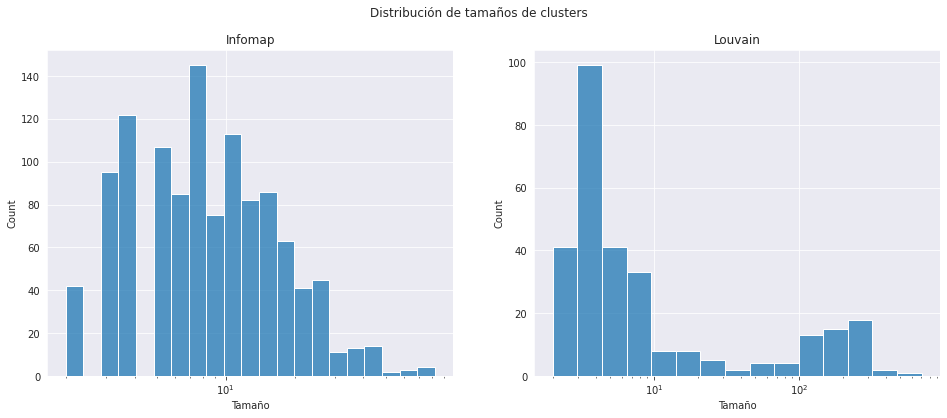

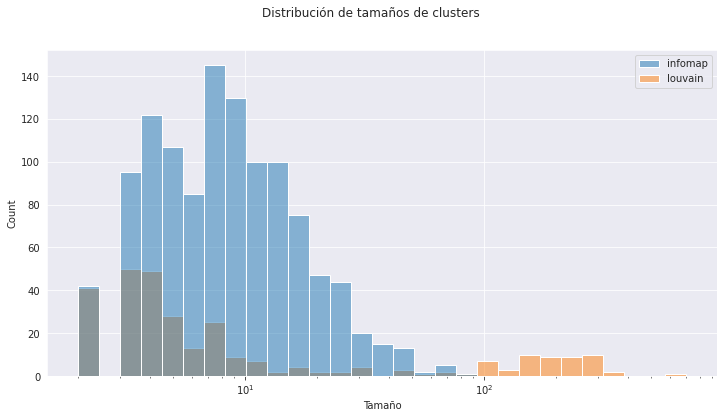

In [71]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Distribución de tamaños de clusters")
ticks = np.logspace(0,tamaños_infomap.max(),10)

sns.histplot(data=tamaños_infomap, log_scale=True, ax=ax[0])
ax[0].set_xlabel("Tamaño")
ax[0].set_title("Infomap")

sns.histplot(data=tamaños_louvain, log_scale=True, ax=ax[1])
ax[1].set_xlabel("Tamaño")
ax[1].set_title("Louvain")

fig2, ax2 = plt.subplots(figsize=(12,6))
sns.histplot(data=pd.DataFrame({"infomap":tamaños_infomap,"louvain":tamaños_louvain}), log_scale=True,ax=ax2, palette="tab10")
fig2.suptitle("Distribución de tamaños de clusters")
ax2.set_xlabel("Tamaño")

Write data

In [72]:
# nx.write_gml(DD,graph_data+"nohub_disease_layer.gml")

# Distribución de grado

Veo distribución de grado para distintos sub grafos

In [73]:
def get_degree_series(G,name):
    degrees = {n[0]:G.degree(n[0]) for n in G.nodes(data=True)}
    return pd.Series(degrees,name=name)

Acá estoy usando el indice como si fuera node index y no es

In [74]:
dd_degree = get_degree_series(DD,"degree_dd")
nodos_enfermedades = pd.merge(nodos_enfermedades,dd_degree,left_on="node_index",right_index=True,how="left")

ppi_degree = get_degree_series(PPI,"degree_pp")
nodos_proteinas = pd.merge(nodos_proteinas,ppi_degree,left_on="node_index",right_index=True,how="left")

gda_degree = get_degree_series(GDA,"degree_gda")
nodos_gda = pd.merge(nodos_gda,gda_degree,left_on="node_index",right_index=True,how="left")

In [75]:
fig_dd_degree = px.histogram(dd_degree, log_y=True, title="Distribución de grado - enfermedad-enfermedad")
fig_dd_degree.show()

In [76]:
fig_ppi_degree = px.histogram(ppi_degree, log_y=True, title="Distribución de grado - proteina-proteina")
fig_ppi_degree.show()

In [77]:
fig_gda_degree = px.histogram(gda_degree, log_y=True, title="Distribución de grado - gen-enfermedad")
fig_gda_degree.show()

Veo los nodos de mayor grado en cada subred

In [78]:
nodos_gda.sort_values(by="degree_gda", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_gda
17,18773,C0006142,Malignant neoplasm of breast,disease,disgenet,1074.0
8,20754,C0036341,Schizophrenia,disease,disgenet,883.0
71,19957,C0023893,"Liver Cirrhosis, Experimental",disease,disgenet,774.0
1178,18978,C0009402,Colorectal Carcinoma,disease,disgenet,702.0
16,24165,C0376358,Malignant neoplasm of prostate,disease,disgenet,616.0
...,...,...,...,...,...,...
35834,30820,C3151471,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",disease,disgenet,NaN
35835,30959,C3278148,"BERNARD-SOULIER SYNDROME, TYPE A1",disease,disgenet,NaN
35836,33955,C4722518,Triple-Negative Breast Carcinoma,disease,disgenet,NaN
35837,32968,C4289709,DOCK8 Deficiency,disease,disgenet,NaN


In [79]:
nodos_enfermedades.sort_values(by="degree_dd", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_dd
13731,9958,5113_5550_5108,infectious disease,bert_group,primekg,98.0
13235,3072,14866_12012_33850_11890_11687_12014_13758_1156...,Charcot-Marie-Tooth disease,bert_group,primekg,90.0
8042,865,10632_33369_33371_10472_14477_32598_10396_3276...,developmental and epileptic encephalopathy,bert_group,primekg,80.0
16884,2788,14302_12928_14568_12867_12766_13132_13239_1148...,hereditary spastic paraplegia,bert_group,primekg,78.0
14098,2421,13274_10761_10945_8378_12796_910_11272_13611_1...,retinitis pigmentosa,bert_group,primekg,76.0
...,...,...,...,...,...,...
33726,21893,C0175703,Thrombocytopenia-Absent Radius Syndrome,disease,disgenet,NaN
33744,31677,C3698541,"Ohdo syndrome, Maat-Kievit-Brunner type",disease,disgenet,NaN
33745,25756,C0796094,Blepharophimosis syndrome Ohdo type,disease,disgenet,NaN
33751,20218,C0027645,Neoplasm Seeding,disease,disgenet,NaN


In [80]:
nodos_proteinas.sort_values(by="degree_pp", ascending=False)

,node_index,node_id,node_name,node_type,node_source,degree_pp
179,4293,2099,ESR1,gene_protein,disgenet,625.0
1665,9316,4609,MYC,gene_protein,disgenet,610.0
429,14317,7157,TP53,gene_protein,disgenet,523.0
425,13810,6613,SUMO2,gene_protein,hippie,508.0
11,35548,R-HSA-6798695,Neutrophil degranulation,pathway,primekg_REACTOME,478.0
...,...,...,...,...,...,...
33689,18243,98,ACYP2,gene_protein,disgenet,NaN
33711,18316,9881,TRANK1,gene_protein,disgenet,NaN
33712,18319,9884,LRRC37A,gene_protein,disgenet,NaN
33718,18353,9920,KBTBD11,gene_protein,disgenet,NaN


Integro todo en un solo dataset

In [81]:
graph_node_data = pd.merge(graph_node_data,nodos_gda[["node_index","degree_gda"]],how="left",left_on="node_index",right_on="node_index")
graph_node_data.degree_gda = graph_node_data.degree_gda.fillna(0)

graph_node_data = pd.merge(graph_node_data,nodos_proteinas[["node_index","degree_pp"]],how="left",left_on="node_index",right_on="node_index")
graph_node_data.degree_pp = graph_node_data.degree_pp.fillna(0)

graph_node_data = pd.merge(graph_node_data,nodos_enfermedades[["node_index","degree_dd"]],how="left",left_on="node_index",right_on="node_index")
graph_node_data.degree_dd = graph_node_data.degree_dd.fillna(0)

In [111]:
# graph_node_data.to_csv(graph_data+"nohub_graph_node_data.csv",index=False)

# Comparo grado inter-capa e intra-capa

Quiero ver cuantos nodos me quedaron "aislados" en su capa, es decir, tienen enlaces con otra capa pero no están interconectados dentro de su capa:

K_intra_inter

K11 = enlaces inter e intra capa

K01 = solo enlaces inter capa

K10 = solo enlaces intra capa

In [83]:
def k_inter_intra(type,degree_type):
    #nodos con enlaces intercapa pero sin enlaces intra capa
    nodes_k01 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda != 0) & (graph_node_data[degree_type] == 0)])

    #nodos con enlaces intra capa y sin enlaces inter capa
    nodes_k10 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda == 0) & (graph_node_data[degree_type] != 0)])

    #nodos con enlaces intra e inter capa
    nodes_k11 = len(graph_node_data[(graph_node_data.node_type == type) & (graph_node_data.degree_gda != 0) & (graph_node_data[degree_type] != 0)])

    total = len(graph_node_data[graph_node_data.node_type == type])
    values = [(nodes_k11*100)/total, (nodes_k10*100)/total, (nodes_k01*100)/total]

    return (values)

In [84]:
k_prot = k_inter_intra("gene_protein","degree_pp")
k_enf = k_inter_intra("disease","degree_dd")

Text(0.5, 1.0, 'Nodos enfermedad')

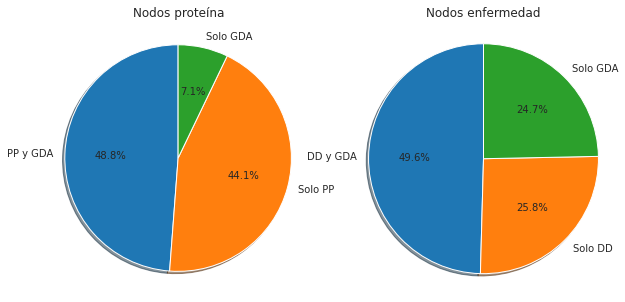

In [85]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].pie(k_prot, labels=["PP y GDA", "Solo PP", "Solo GDA"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[0].axis('equal') 
ax[0].set_title("Nodos proteína")

ax[1].pie(k_enf, labels=["DD y GDA", "Solo DD", "Solo GDA"], autopct='%1.1f%%',shadow=True, startangle=90)
ax[1].axis('equal')
ax[1].set_title("Nodos enfermedad")

In [86]:
fig_pd_degree = px.histogram(graph_node_data[(graph_node_data.node_type == "gene_protein") & (graph_node_data.degree_gda !=0)]["degree_gda"], log_y=True, title="Distribución de grado: nodos gen -> nodos enfermedad")
fig_pd_degree.show()

In [87]:
fig_dp_degree = px.histogram(graph_node_data[(graph_node_data.node_type == "disease") & (graph_node_data.degree_gda !=0)]["degree_gda"], log_y=True, title="Distribución de grado: nodos enfermedad -> nodos gen")
fig_dp_degree.show()

# Comunidades - MESH

In [88]:
def nombre_mesh(meshclass):
    nombre = pd.unique(disease_attributes[disease_attributes.diseaseClassMSH == meshclass]["diseaseClassNameMSH"])
    return nombre

mesh_names = {mesh:nombre_mesh(mesh) for mesh in pd.unique(disease_attributes[~disease_attributes.diseaseClassMSH.isna()].diseaseClassMSH)}

In [89]:
mesh_col = disease_attributes[~disease_attributes.diseaseClassMSH.isna()]['diseaseClassMSH'].str.split(';').explode()
meshname_col = disease_attributes[~disease_attributes.diseaseClassMSH.isna()]['diseaseClassNameMSH'].str.split(';').explode()
mesh_df = pd.concat([mesh_col,meshname_col], axis=1).drop_duplicates(subset=["diseaseClassMSH"]).reset_index(drop=True)

In [90]:
disease_attr_communities = pd.merge(disease_attributes, graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]], left_on="node_index", right_on="node_index", how="left")

In [91]:
def mesh_from_cluster(cluster_id,method):
    if method == "infomap":
        cluster_nodes = disease_attr_communities[(disease_attr_communities.comunidades_infomap == cluster_id) & (disease_attr_communities.diseaseClassMSH.notna())]
        cluster_nodes_noclass = len(disease_attr_communities[(disease_attr_communities.comunidades_infomap == cluster_id) & (disease_attr_communities.diseaseClassMSH.isna())])
        total_nodes = len(disease_attr_communities[disease_attr_communities.comunidades_infomap == cluster_id])
    elif method == "louvain":
        cluster_nodes = disease_attr_communities[(disease_attr_communities.comunidades_louvain == cluster_id) & (disease_attr_communities.diseaseClassMSH.notna())]
        cluster_nodes_noclass = len(disease_attr_communities[(disease_attr_communities.comunidades_louvain == cluster_id) & (disease_attr_communities.diseaseClassMSH.isna())])
        total_nodes = len(disease_attr_communities[disease_attr_communities.comunidades_louvain == cluster_id])

    mesh_classes = cluster_nodes.diseaseClassMSH.values
    classes = []
    for value in mesh_classes:
        split = value.split(";")
        for mesh_class in split:
            classes.append(mesh_class)
    fig = px.histogram(classes, title=f"Clases de Mesh representadas en el cluster {cluster_id}").update_layout(xaxis_title="Mesh Class")
    fig.show()
    #print(f"Este cluster tiene {total_nodes} nodos, de los cuales {cluster_nodes_noclass} no tienen clase mesh. \nFueron contados {len(cluster_nodes)} nodos")
    print(f"Nodos en gráfico: {len(cluster_nodes)} \nNodos totales cluster: {total_nodes} \nNodos sin clase mesh: {cluster_nodes_noclass}")

In [92]:
mesh_df.sort_values(by="diseaseClassMSH")

,diseaseClassMSH,diseaseClassNameMSH
22,C01,Infections
3,C04,Neoplasms
19,C05,Musculoskeletal Diseases
1,C06,Digestive System Diseases
20,C07,Stomatognathic Diseases
14,C08,Respiratory Tract Diseases
21,C09,Otorhinolaryngologic Diseases
13,C10,Nervous System Diseases
18,C11,Eye Diseases
4,C12,Male Urogenital Diseases


In [93]:
tamaños_louvain

3      702
18     369
16     333
33     304
14     304
      ... 
262      2
177      2
264      2
265      2
144      2
Name: tamaño, Length: 294, dtype: int64

In [94]:
mesh_from_cluster(3,"louvain")

Nodos en gráfico: 583 
Nodos totales cluster: 702 
Nodos sin clase mesh: 119


También puedo ver entropía con "vectores mesh"

# Distancias intercapa

In [95]:
nodes_in_graph = np.unique(np.concatenate([graph_edge_data.x_index.astype("int").values,graph_edge_data.y_index.astype("int").values]))
graph_node_data[graph_node_data.node_index.apply(lambda x: x not in nodes_in_graph)].node_source.value_counts()
graph_node_data = graph_node_data[graph_node_data.node_index.apply(lambda x: x in nodes_in_graph)]
graph_node_data

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
0,0,1,A1BG,gene_protein,disgenet,NaN,NaN,2.0,12.0,0.0
1,19599,C0019209,Hepatomegaly,disease,disgenet,NaN,NaN,54.0,0.0,0.0
2,34251,R-HSA-114608,Platelet degranulation,pathway,primekg_REACTOME,NaN,NaN,0.0,129.0,0.0
3,653,10422,UBAC1,gene_protein,hippie,NaN,NaN,0.0,36.0,0.0
4,13168,63891,RNF123,gene_protein,disgenet,NaN,NaN,2.0,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35834,30820,C3151471,"AMYLOID CARDIOMYOPATHY, TRANSTHYRETIN-RELATED",disease,disgenet,766.0,22.0,0.0,0.0,1.0
35835,30959,C3278148,"BERNARD-SOULIER SYNDROME, TYPE A1",disease,disgenet,1106.0,252.0,0.0,0.0,1.0
35836,33955,C4722518,Triple-Negative Breast Carcinoma,disease,disgenet,17.0,2.0,0.0,0.0,1.0
35837,32968,C4289709,DOCK8 Deficiency,disease,disgenet,127.0,17.0,0.0,0.0,1.0


In [96]:
nodos_intracapa = graph_node_data[graph_node_data.degree_gda == 0]
enf_intracapa = nodos_intracapa[(nodos_intracapa.node_type == "disease") | (nodos_intracapa.node_type == "bert_group")].node_index.astype("int").values
gen_intracapa = nodos_intracapa[(nodos_intracapa.node_type == "gene_protein")].node_index.astype("int").values
complejos_intracapa = nodos_intracapa[nodos_intracapa.node_type == "complex"].node_index.astype("int").values
pathways_intracapa = nodos_intracapa[nodos_intracapa.node_type == "pathway"].node_index.astype("int").values

#all_genes = graph_node_data[graph_node_data.node_type == "gene/protein"].node_index.values
#all_enf = graph_node_data[graph_node_data.node_type == "disease"].node_index.values
gen_intercapa = graph_node_data[(graph_node_data.degree_gda != 0) & (graph_node_data.node_type == "gene_protein")].node_index.astype("int").values
enf_intercapa = graph_node_data[(graph_node_data.degree_gda != 0) & (graph_node_data.node_type == "disease")].node_index.astype("int").values

Armo una versión igraph de mi grafo. Como igraph usa otra forma de indexar los nodos, me armo diccionarios para "traducir" entre mi nomenclatura y la de igraph.

In [97]:
G_igraph = ig.Graph.TupleList(G.edges(), directed=False)

#Tengo que "traducir" los ids de mi grafo a ids de igraph
vid2name = dict(zip(range(G_igraph.vcount()), G_igraph.vs['name']))
name2vid = dict((name, vid) for vid, name in vid2name.items())
gen_intercapa_vid = [name2vid[gen] for gen in gen_intercapa]
enf_intercapa_vid = [name2vid[enf] for enf in enf_intercapa]

In [98]:
results_enf = {}
for enf in enf_intracapa:
    igraph_id = name2vid[enf]
    results_enf[enf] = min(G_igraph.shortest_paths(igraph_id,gen_intercapa_vid,mode="out")[0])

In [99]:
results_gen = {}
for gen in gen_intracapa:
    igraph_id = name2vid[gen]
    results_gen[gen] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [100]:
results_complex = {}
for com in complejos_intracapa:
    igraph_id = name2vid[com]
    results_complex[com] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [101]:
results_pathway = {}
for pth in pathways_intracapa:
    igraph_id = name2vid[pth]
    results_pathway[pth] = min(G_igraph.shortest_paths(igraph_id,enf_intercapa_vid,mode="out")[0])

In [102]:
shortest_interlayer_length = pd.Series(pd.concat([pd.Series(results_enf, dtype="float64"),pd.Series(results_gen, dtype="float64"), pd.Series(results_complex, dtype="float64"),pd.Series(results_pathway, dtype="float64")]),name="Shortest_interlayer_length")

#le asigno valor negativo a los nodos totalmente desconectados de la otra capa
shortest_interlayer_length = shortest_interlayer_length.apply(lambda x: -1 if x == float("inf") else x)
node_interlayer_data = graph_node_data.join(shortest_interlayer_length, on="node_index")
node_interlayer_data.loc[(graph_node_data["degree_gda"] != 0), 'Shortest_interlayer_length'] = 1

In [104]:
# node_interlayer_data.to_csv(graph_data+"nohub_analisis_grado.csv",index=False)

Para armar figura de 2*3 con todos los gráficos juntos

In [ ]:
# pathways = analisis_grado[analisis_grado.node_type == "pathway"]
# complexes = analisis_grado[analisis_grado.node_type == "complex"]
# genes = analisis_grado[analisis_grado.node_type == "gene_protein"]
# diseases = analisis_grado[analisis_grado.node_type == "disease"]
# berts = analisis_grado[analisis_grado.node_type == "bert_group"]

# cases = {"Todos":analisis_grado, "Enfermedades":diseases, "Genes":genes, "Complejos":complexes, "Pathways":pathways,"BERTs":berts}


# plt.figure(figsize=(24, 12))
# plt.subplots_adjust(hspace=0.5)
# plt.suptitle("Distancia mínima a la otra capa", fontsize=18, y=0.95)

# for n, data in enumerate(cases.items()):
#     ax = plt.subplot(2, 3, n + 1)
#     title = data[0]
#     x = data[1]
#     sns.histplot(data=x, x="Shortest_interlayer_length", ax=ax, bins=[1,2,3,4,5,6,7])
#     ax.set_title(title)
#     ax.set_xlabel("Distancia mínima")

# # plt.savefig("../../reports/distancias.png", dpi=150)

In [105]:
interlayer_fig = px.histogram(node_interlayer_data["Shortest_interlayer_length"], title="All types and cases")
interlayer_fig.show()

In [106]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "disease", "Shortest_interlayer_length"], title="Diseases")
interlayer_fig.show()

In [107]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "gene_protein", "Shortest_interlayer_length"], title="Genes")
interlayer_fig.show()

In [108]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "bert_group", "Shortest_interlayer_length"], title="Bert Groups")
interlayer_fig.show()

In [109]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "complex", "Shortest_interlayer_length"], title="Protein Complex")
interlayer_fig.show()

In [110]:
interlayer_fig = px.histogram(node_interlayer_data.loc[graph_node_data["node_type"] == "pathway", "Shortest_interlayer_length"], title="Pathways")
interlayer_fig.show()